### Namen en studentnummers:

 **Murielle Tichelaar** (500926485)  
 **Nalini Bisessar** (500874334)  
 **Lushan Strack** (500934278)  
 **Dinand Voogt** (500934202) 

### Projectinformatie:

**Opleiding:** Toegepaste Wiskunde & Data Science  
**Vak:** Beroepsproject 3.4  
**Begeleider:** R. Nolet  
**Datum:** 20-02-2026  

### Doel/opdracht van het bestand:
Evaluatie

### Omschrijving van het bestand:
Dit bestand voert de evaluatie van het getrainde model uit op het testbestand.
Het model wordt toegepast op ongeziene (schone) data.

De volgende stappen worden uitgevoerd:
- Genereren van een classification report
- Plotten van de confusion matrix
- Vergelijken van de verwachte winst met de maximaal haalbare winst

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, Latex

In [2]:
# Functies
def latex_cr(cr):
    c0 = cr['0']
    c1 = cr['1']
    macro = cr['macro avg']
    weighted = cr['weighted avg']
    acc = cr['accuracy']

    output = rf"""
$$
\begin{{array}}{{lrrrr}}
\text{{}} & \text{{Precision}} & \text{{Recall}} & \text{{F1-score}} & \text{{Support}} \\\hline
0 & {c0['precision']:.2f} & {c0['recall']:.2f} & {c0['f1-score']:.2f} & {c0['support']:.0f} \\
1 & {c1['precision']:.2f} & {c1['recall']:.2f} & {c1['f1-score']:.2f} & {c1['support']:.0f} \\\hline
\text{{accuracy}} & & & {acc:.2f} & \\
\text{{macro avg}} & {macro['precision']:.2f} & {macro['recall']:.2f} & {macro['f1-score']:.2f} & {macro['support']:.0f} \\
\text{{weighted avg}} & {weighted['precision']:.2f} & {weighted['recall']:.2f} & {weighted['f1-score']:.2f} & {weighted['support']:.0f}
\end{{array}}
$$
"""
    return Latex(output)

def plot_cm(y_true, y_pred, classes=None, title="Confusion Matrix"):

    sns.set_style("white")
    plt.rcParams.update({"font.family": "DejaVu Sans", "font.size": 11})

    fig, ax = plt.subplots(figsize=(8, 5))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=classes,
        cmap="Blues",
        colorbar=True,
        ax=ax,
        include_values=False
    )

    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    threshold = cm.max() / 2

    labels = [["True Negative", "False Positive"],
              ["False Negative", "True Positive"]]

    for i in range(2):
        for j in range(2):
            value = cm[i, j]
            color = "white" if value > threshold else "#1f2937"

            ax.text(j, i-0.25, labels[i][j],
                    ha="center", fontsize=9, color=color)

            ax.text(j, i, f"{value:,}",
                    ha="center", va="center",
                    fontsize=22, fontweight="bold", color=color)

            ax.text(j, i+0.25, f"{value/total*100:.1f}%",
                    ha="center", fontsize=10, color=color)

    plt.title(title, fontsize=17, fontweight="semibold")
    plt.figtext(0.98, 0.02, f"Total samples: {total:,}",
                ha="right", fontsize=9, color="#6B7280")

    plt.tight_layout()
    plt.show()


In [ ]:
# Inladen pipeline bestand
model_pipeline = joblib.load("../../data/model_pipeline.joblib")
test_path = "../../data/data_test.csv" 
df = pd.read_csv(test_path, sep=",", decimal=".")

In [4]:
# Scheiden van target en input variabelen
target = "Churn"

X = df.drop(columns=[target])
y = df[target]

X.shape, y.shape

((855, 9), (855,))

In [5]:
# Voorspel de kans op Churn
y_pred = model_pipeline.predict(X)
y_prob = model_pipeline.predict_proba(X)[:,1]  # kans dat Churn = 1

In [6]:
#Voorspellen wie tarief 2 krijgt
# Winstvergelijkingen
W1 = 0.1 * X["Frequency of SMS"] + 0.3 * X["Seconds of Use"]
W2 = 0.07 * X["Frequency of SMS"] + 0.2 * X["Seconds of Use"]

# Balansvergelijking
df['thresholds'] = (W1-W2)/(W1-(W2*0.75))

# Voorspellen wie tarief 2
offer_tarief2 = (y_prob >= df["thresholds"]).astype(int)

In [7]:
# Toevoegen aan dataframe
df["Voorspelde_kans_churn"] = y_prob
df["Tarief2_aanbieden"] = offer_tarief2

print("Aantal klanten tarief 2 (test):", int(offer_tarief2.sum()))


Aantal klanten tarief 2 (test): 48


In [8]:
display(latex_cr(classification_report(y, y_pred, zero_division=True, output_dict=True)))

<IPython.core.display.Latex object>

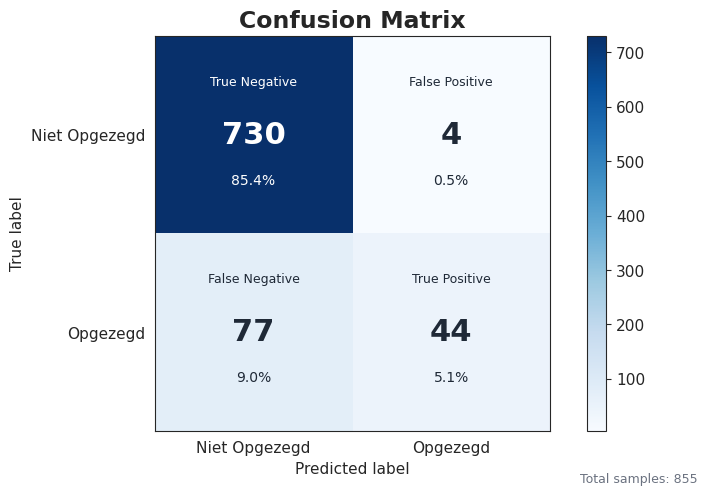

In [9]:
# Confusion matrix
class_names = ["Niet Opgezegd", "Opgezegd"] 
plot_cm(y, offer_tarief2, classes=class_names)

In [18]:
# Winst omzetten naar per maand
sms_pm = X["Frequency of SMS"] / 9
min_pm = (X["Seconds of Use"] / 60) / 9

W1_pm = 0.1 * sms_pm + 0.3 * min_pm
W2_pm = 0.07 * sms_pm + 0.2 * min_pm

# Verwachte winst per klant per maand
E_tarief1 = (1 - y_prob) * W1_pm
E_tarief2 = (1 - 0.75 * y_prob) * W2_pm

# Totale verwachte winst
totale_winst1 = E_tarief2[offer_tarief2 == 1].sum() + E_tarief1[offer_tarief2 == 0].sum()
print("Predicted:")
print("Aantal klanten tarief 2 (train):", int(offer_tarief2.sum()))
print("Totaal aantal klanten (train):", len(X))
print("Totale verwachte maandelijkse winst (train):", round(float(totale_winst1), 2))

# Baselines
print("Winst als altijd tarief 1:", round(float(E_tarief1.sum()), 2))
print("Winst als altijd tarief 2:", round(float(E_tarief2.sum()), 2))




# maximum winst per klant per maand
E_tarief1 = (1 - y) * W1_pm
E_tarief2 = (1 - 0.75 * y) * W2_pm

# Totale maximum winst 
totale_winst2 = E_tarief2[offer_tarief2 == 1].sum() + E_tarief1[offer_tarief2 == 0].sum()
print(" ")
print("Maximum:")
print("Aantal klanten tarief 2 (test):", int(y.sum()))
print("Totaal aantal klanten (test):", len(X))
print("Totale maandelijkse winst haalbaar (test):", round(float(totale_winst2), 2))
print("Verschil is rond:", round(float(totale_winst2 - totale_winst1), 2))

Predicted:
Aantal klanten tarief 2 (train): 48
Totaal aantal klanten (train): 855
Totale verwachte maandelijkse winst (train): 2713.67
Winst als altijd tarief 1: 2705.83
Winst als altijd tarief 2: 1848.66
 
Maximum:
Aantal klanten tarief 2 (test): 121
Totaal aantal klanten (test): 855
Totale maandelijkse winst haalbaar (test): 2733.98
Verschil is rond: 20.31


Op de trainingsdata behaalt het logistieke regressiemodel een totale verwachte maandelijkse winst van 6228.69. Hierbij wordt aan 128 van de 1995 klanten tarief 2 aangeboden. Het dummy model behaalt echter een hogere winst van 6571.17 en biedt aan geen enkele klant tarief 2 aan.

Dit laat zien dat in deze situatie een eenvoudige en conservatieve strategie, niemand tarief 2 aanbieden, winstgevender is dan de strategie van het model. Tarief 2 levert alleen voordeel op wanneer een klant daadwerkelijk zou churnen. Wanneer tarief 2 wordt aangeboden aan klanten die niet zouden vertrekken, leidt dit tot lagere inkomsten. In dit geval weegt dat verlies zwaarder dan het voordeel van het behouden van een kleine groep churners.

Op de testdata zien we een vergelijkbaar beeld. Het model selecteert 48 van de 855 klanten voor tarief 2 en behaalt een verwachte maandelijkse winst van 2713.67. Het verschil met de strategie waarbij altijd tarief 1 wordt aangeboden is hier klein. Dit bevestigt dat het voordeel van het aanbieden van tarief 2 beperkt is.

De resultaten op de trainingsdata en testdata zijn vergelijkbaar. Dit wijst erop dat het model consistent presteert op nieuwe data.